### Imports libraries and Read data

In [350]:
import warnings
warnings.filterwarnings('ignore')

In [351]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [352]:
random_state = 42  # For reproducibility
sns.set_theme(style="darkgrid", font_scale=1, rc={"axes.titlesize":18}, palette="Set1")


In [353]:
url = "https://raw.githubusercontent.com/sagnikghoshcr7/Bank-Customer-Churn-Prediction/master/Churn_Modelling.csv"
df = pd.read_csv(url, header=0, index_col=0)


In [354]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [355]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


There is no null value in the dataset.

#### check duplicates data 

In [356]:
df.duplicated().any()

False

There is no duplicate data in the dataset.

### Exploratory Data Analysis (EDA) & Feature Preprocessing

In [357]:
df.drop(columns=["CustomerId","Surname"], inplace = True)

In [358]:
categorical = ["Geography", "Gender", "Tenure", "NumOfProducts", "HasCrCard", "IsActiveMember"]
numerical = ["CreditScore", "Age", "Balance", "EstimatedSalary"]

In [359]:
df["Exited"] = df["Exited"].astype("category")

In [360]:
for i in categorical:
    df[i] = df[i].astype("category")

In [361]:
for i in numerical:
    df[i] = df[i].astype("float64")

In [362]:
df_num = df.select_dtypes(include=np.number)

#### Outlier Treatment

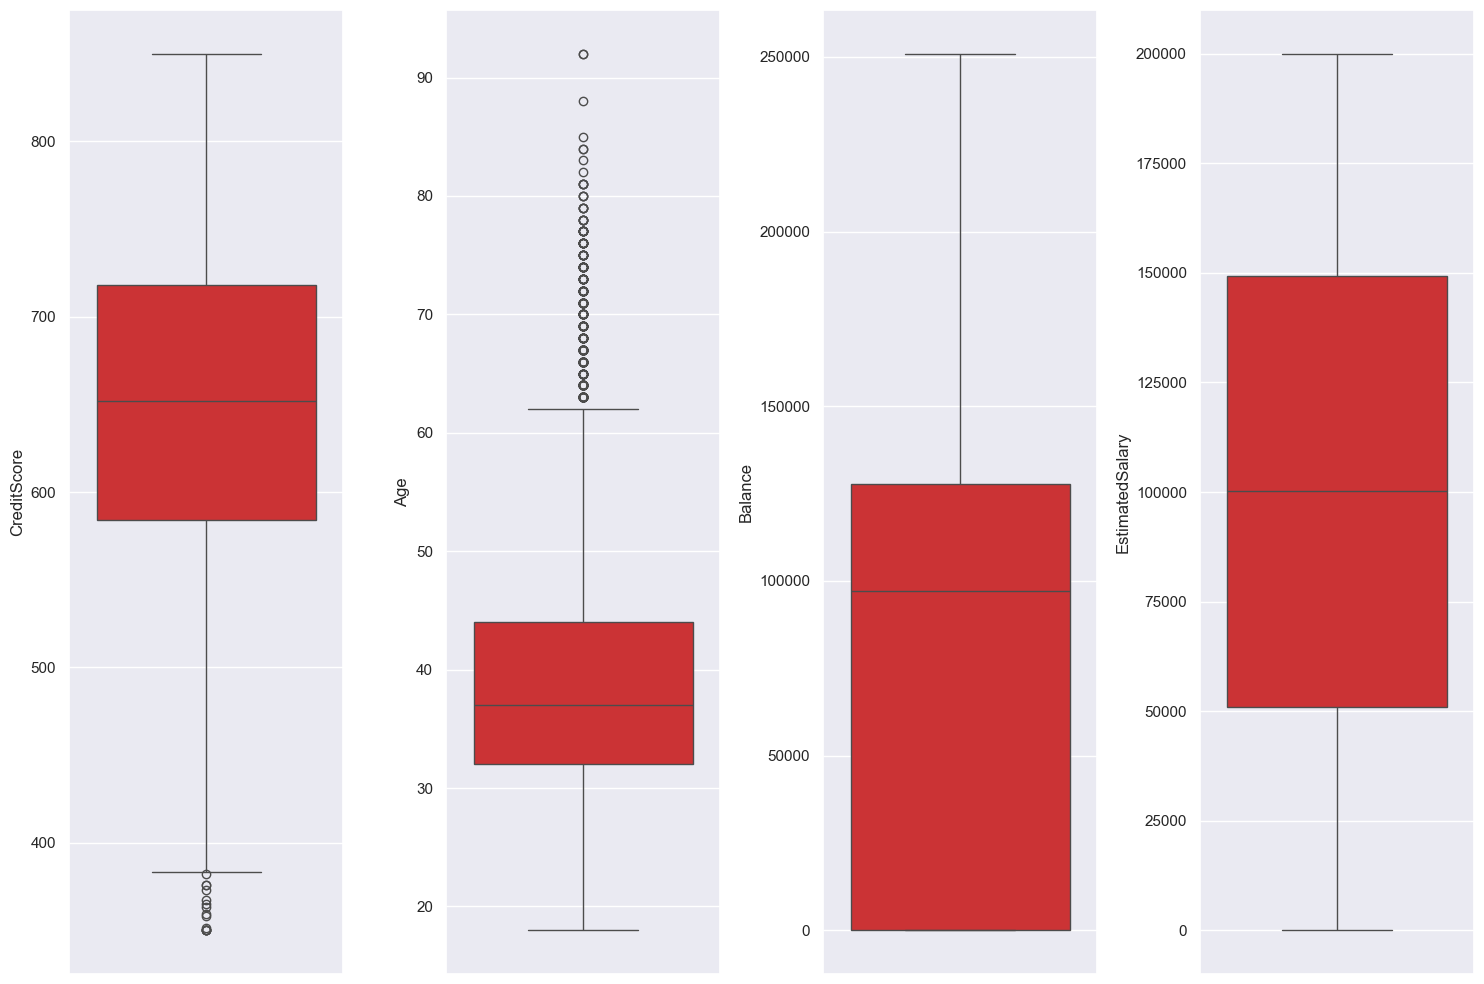

In [363]:
plt.figure (figsize=(15,10))

for i in range(len(numerical)):
    plt.subplot(1,len(numerical),i+1)
    sns.boxplot(df[numerical[i]])
    plt.tight_layout()

Credit Score has outliers. We will remove them using z-score.
Age looks some data is outliear but we will not remove them as it is possible that some customers are old.

In [364]:
import scipy.stats as stats

In [365]:
zscores = np.abs(stats.zscore(df["CreditScore"]))
filter = zscores < 3
df_clean = df[filter]
print("number of outliers removed:", zscores.shape[0] - filter.sum())

number of outliers removed: 8


#### Split the data into train and test

In [366]:
from sklearn.model_selection import train_test_split

In [367]:
df_train, df_test = train_test_split(df_clean, test_size=0.2, random_state=random_state)

#### Exploratory Data Analysis ####

##### Target variable #####

In [368]:
Exit_label = {1:"Exited", 0:"Retained"}
custom_palette = {'1': 'red', '0': 'blue'}
custom_palette2 = {1: 'red', 0: 'blue'} # for the legend and hue


In [369]:
def add_values_labels(ax):
    total = sum([p.get_height() for p in ax.patches])
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100*p.get_height()/total)  # format as percentage
        ax.annotate(percentage, (p.get_x()+p.get_width()/2.,p.get_height()), ha = "center", va="center", xytext=(0,5), fontsize=12, color="black",textcoords='offset points')


In [370]:
df["Exited"].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of Exited and Retained Customers')

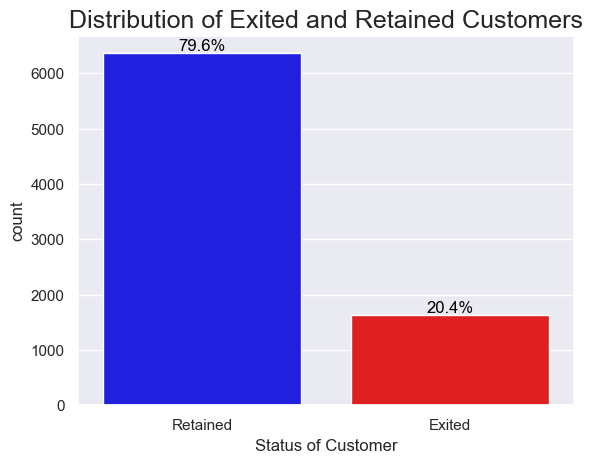

In [371]:
ax = sns.countplot(data=df_train, x="Exited", palette=custom_palette)
add_values_labels(ax)
ax.set_xticklabels(reversed(Exit_label.values()))
ax.set_xlabel("Status of Customer")
ax.set_title("Distribution of Exited and Retained Customers")


From distribution above we can see that the data is imbalanced. We will use SMOTE to balance the data.

#### Numeric Features

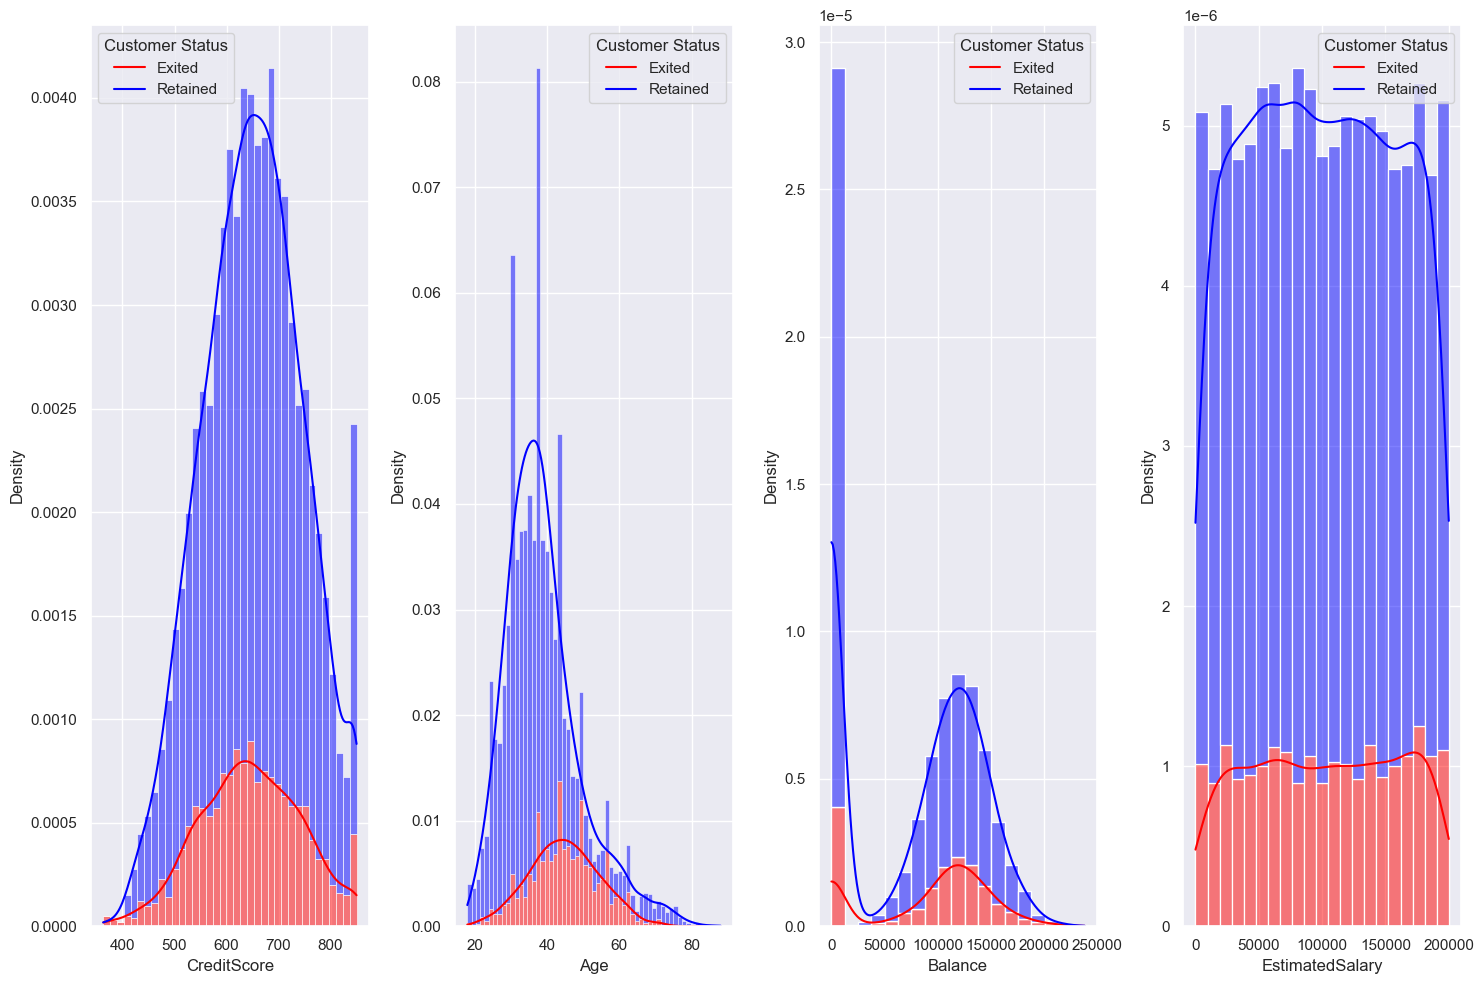

In [372]:
plt.figure(figsize=(15,10))

for i in range(len(numerical)):
    plt.subplot(1,len(numerical),i+1)
    sns.histplot(data=df_train, x=numerical[i], kde=True, hue="Exited", stat="density", palette=custom_palette2, alpha=0.5,multiple="stack")
    plt.legend(title="Customer Status", labels=Exit_label.values())
    plt.tight_layout()


for distribution plot we can see if there are features have skewness. We need to do some transformation to make the data more normal distribution.
if we see from peak of distribution from these features. We can see feature "Age" has different peak distribution between "Exited" and "Retained" that means that features importance to the status of customer 

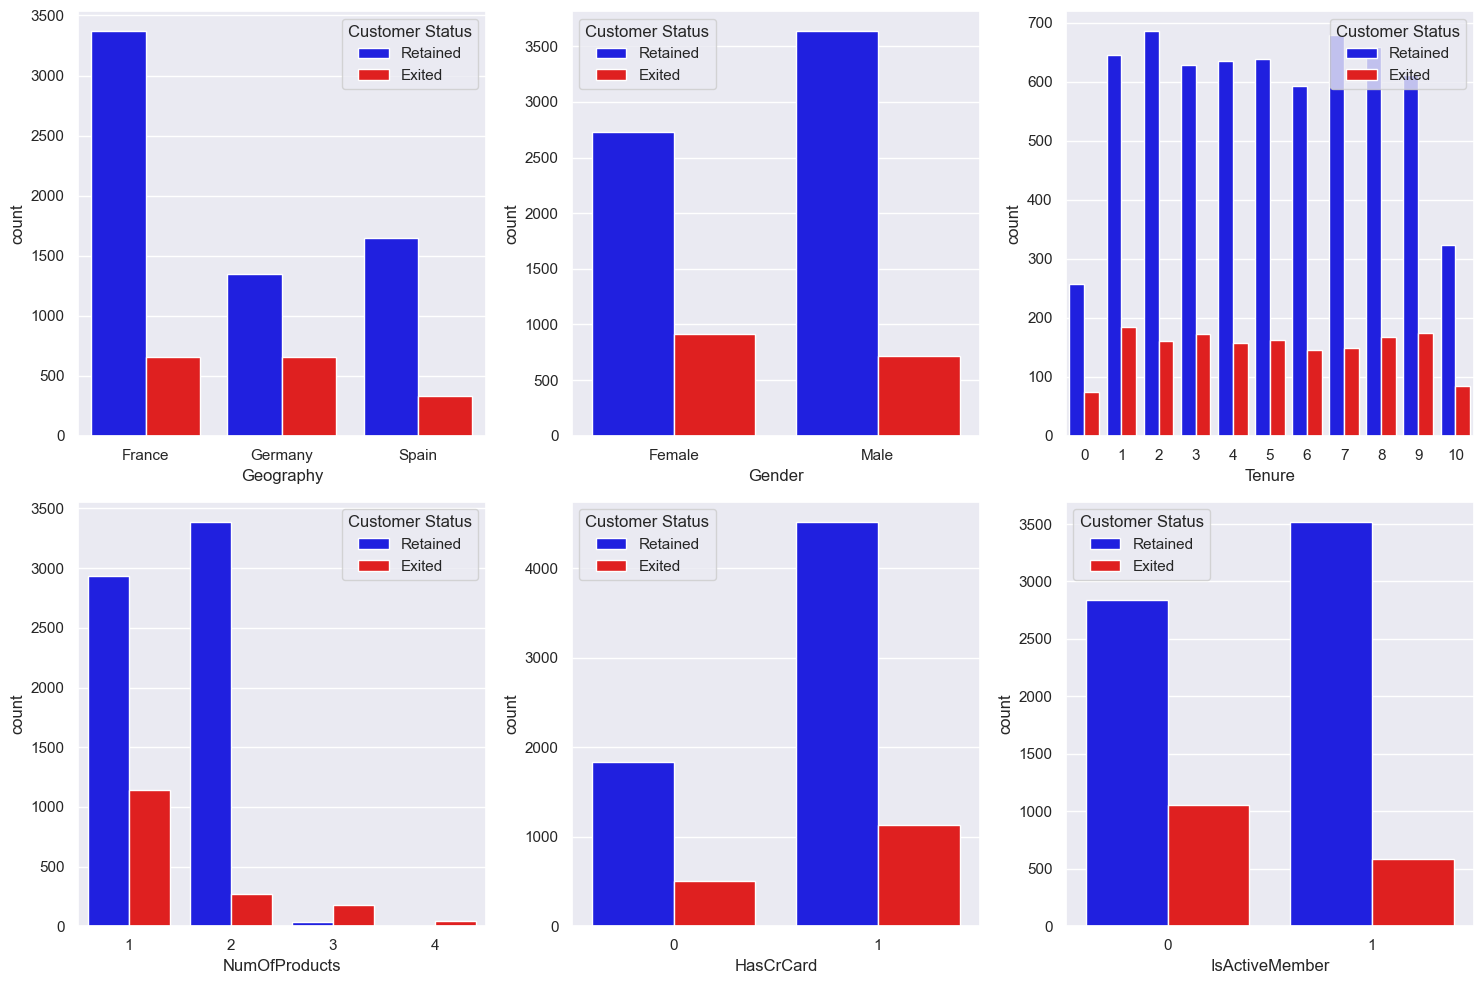

In [373]:
plt.figure(figsize=(15,10))

for i in range (len(categorical)):
    plt.subplot(2,3,i+1)
    sns.countplot(data=df_train, x=categorical[i], hue="Exited", palette=custom_palette2)
    plt.legend(title="Customer Status", labels=list(Exit_label.values())[::-1])
    plt.tight_layout()

- **Geography**

If we see from the distribution of the customers, we can see that most of the customers are from France, followed by Germany and Spain. But if we see the distribution of the customers who exited, we can see that most of the customers who exited are from Germany, followed by France and Spain. So, we can say that the customers from Germany are more likely to exit.


- **Gender**

The most customer is male then female is more likely to exit.  

- **Tenure**

it is difficult to say anything from the tenure distribution. But we can see that the customers who exited are more likely to have a tenure of 1 year.

- **NumOfProducts**

the most customer have 1 product and the most customer who exited have 1 product.

- **HasCrCard**

the most customer have credit card and the customer who does not have credit card is more likely to exit.

- **IsActiveMember**

the most customer is active and the customer who is not active is more likely to exit.

### Feature Engineering

#### Numerical Features

<Axes: >

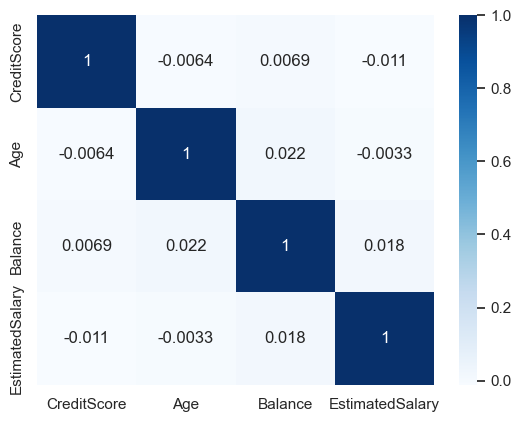

In [374]:
sns.heatmap(df_train[numerical].corr(), annot =True, cmap="Blues")

there is no significant correlation between the numerical features or intercorrelation between them

In [375]:
from sklearn.preprocessing import StandardScaler

we will use the StandardScaler to transform the features "CreditScore" and "Age" using the Standard Normal Distribution (mean=0, std=1)

In [376]:
scaler = StandardScaler()

def ScalerData(data):
    data[["CreditScore_scaler", "Age_scaler"]] = scaler.fit_transform(data[["CreditScore", "Age"]])
    data.drop(columns=["CreditScore", "Age"], inplace=True)
    return data

In [377]:
df_train = ScalerData(df_train)
df_test = ScalerData(df_test)

#### Categorical Features

In [378]:
df_train[categorical].head()

,Geography,Gender,Tenure,NumOfProducts,HasCrCard,IsActiveMember
RowNumber,,,,,,
5855,France,Female,5,2,1,1
169,Spain,Female,2,2,1,0
8961,Germany,Female,8,1,1,0
7487,France,Male,8,2,0,0
9529,France,Male,9,1,1,0


One of methods to feature selection in particular categorical data is to use chi-square test. The chi-square test is used to determine whether there is a significant difference between the expected frequencies and the observed frequencies in one or more categories.

we will do one hot encoding for the categorical variablesfor "Geography" and "Gender"

In [379]:
from scipy.stats import chi2_contingency


In [380]:
chi2_value = []
p_value = []

for col in categorical:
    category_data = pd.crosstab(df_train[col],df_train["Exited"])
    chi2, p, dof, expected = chi2_contingency(category_data.values)
    chi2_value.append(chi2)
    p_value.append(p)

chi2_test = pd.DataFrame({"Feature":categorical, "Chi2":chi2, "P-Value":p_value})


In [381]:
chi2_test.sort_values(by="P-Value")

,Feature,Chi2,P-Value
3,NumOfProducts,201.184621,1.962586e-263
0,Geography,201.184621,1.040053e-54
5,IsActiveMember,201.184621,1.151662e-45
1,Gender,201.184621,6.347345e-21
4,HasCrCard,201.184621,1.531739e-01
2,Tenure,201.184621,5.435709e-01


Based on chi2 test that focus to p-value. We can see if "HasCrCard" and "Tenure" has a value more than 0.05. It means we will reject null hypothesis or not significant or drop those features

In [382]:
df_train.drop(["HasCrCard", "Tenure"], axis=1, inplace=True)
df_test.drop(["HasCrCard", "Tenure"], axis=1, inplace=True)

In [383]:
encoder= OneHotEncoder(drop="first", sparse=False)

def EncoderData(data):
    data_encoder = encoder.fit_transform(data[["Geography","Gender"]])
    data = pd.merge(data, pd.DataFrame(data_encoder, columns=encoder.get_feature_names_out()), left_index=True, right_index=True)
    data.drop(["Geography","Gender"], axis=1, inplace=True)
    return data

In [384]:
df_train = EncoderData(df_train)
df_test = EncoderData(df_test)

In [385]:
df_train.head()

,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Exited,CreditScore_scaler,Age_scaler,Geography_Germany,Geography_Spain,Gender_Male
5855,0.00,2,1,125253.46,0,-1.770867,-0.466961,0.0,0.0,0.0
169,0.00,2,0,40721.24,1,0.165185,0.009210,0.0,0.0,0.0
7487,0.00,2,0,157822.54,0,1.695291,0.961553,0.0,0.0,1.0
2124,109175.14,2,0,114566.47,0,-0.001357,-1.324070,0.0,0.0,1.0
5741,102251.57,1,0,120672.09,0,-0.324032,-0.466961,0.0,0.0,1.0


### Class Imbalance

#### Splitting the data into X and y

In [386]:
X_train = df_train.drop("Exited", axis=1)
y_train = df_train["Exited"]

In [387]:
X_test = df_test.drop("Exited", axis=1)
y_test = df_test["Exited"]

In [388]:
from imblearn import over_sampling, under_sampling

In [389]:
X_over_SMOTE, y_over_SMOTE = over_sampling.SMOTE(random_state=random_state, sampling_strategy=0.75,k_neighbors=3).fit_resample(X_train, y_train)

In [390]:
print('before')
print(pd.Series(y_train).value_counts())
print('after')
print(pd.Series(y_over_SMOTE).value_counts())

before
Exited
0    5054
1    1322
Name: count, dtype: int64
after
Exited
0    5054
1    3790
Name: count, dtype: int64


In [391]:
X_over_SMOTE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8844 entries, 0 to 8843
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Balance             8844 non-null   float64 
 1   NumOfProducts       7707 non-null   category
 2   IsActiveMember      7691 non-null   category
 3   EstimatedSalary     8844 non-null   float64 
 4   CreditScore_scaler  8844 non-null   float64 
 5   Age_scaler          8844 non-null   float64 
 6   Geography_Germany   8844 non-null   float64 
 7   Geography_Spain     8844 non-null   float64 
 8   Gender_Male         8844 non-null   float64 
dtypes: category(2), float64(7)
memory usage: 501.4 KB


In [392]:
from sklearn.impute import SimpleImputer

In [393]:
imputer = SimpleImputer(strategy="most_frequent")
X_over_SMOTE[["NumOfProducts","IsActiveMember"]] = imputer.fit_transform(X_over_SMOTE[["NumOfProducts","IsActiveMember"]])

### Model Building

#### Standard Model ####


In [394]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

In [395]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [402]:
model = {'logreg': LogisticRegression(),
     'svm' : SVC(),
     'rf': RandomForestClassifier(),
     'KNN' : KNeighborsClassifier(),
     'gaussian' : GaussianNB(),
     'DT' : DecisionTreeClassifier(),
     'GBC' : GradientBoostingClassifier(),
     'adaboost' : AdaBoostClassifier(random_state = 42)
    }

evaluation = {
  'recall_test' : recall_score,
  'precision' : precision_score,
  'accuracy' : accuracy_score,
  'f1 score' : f1_score
}

model_result = pd.DataFrame(columns=['model',"recall_train", 'recall_test','precision','accuracy','f1 score'])

for name, model in model.items():
  model.fit(X_over_SMOTE, y_over_SMOTE)
  y_pred = model.predict(X_test)
  recall_train = recall_score(y_over_SMOTE, model.predict(X_over_SMOTE))
  recall_test = recall_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  model_resul = model_resul.loc[len(model_resul)] = [name, recall_test, precision, accuracy, f1]


TypeError: 'numpy.float64' object is not callable

In [403]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
import pandas as pd

# Define the models
models = {
    'logreg': LogisticRegression(),
    'svm': SVC(),
    'rf': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'gaussian': GaussianNB(),
    'DT': DecisionTreeClassifier(),
    'GBC': GradientBoostingClassifier(),
    'adaboost': AdaBoostClassifier(random_state=42)
}

# Define the evaluation metrics
evaluation = {
    'recall_test': recall_score,
    'precision': precision_score,
    'accuracy': accuracy_score,
    'f1 score': f1_score
}

# Create an empty DataFrame to store the results
model_results = pd.DataFrame(columns=['model', 'recall_test', 'precision', 'accuracy', 'f1 score'])

for name, model in models.items():
    # Fit the model
    model.fit(X_over_SMOTE, y_over_SMOTE)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    recall_test = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Append the results to the DataFrame
    model_results = model_results.append({'model': name, 'recall_test': recall_test, 'precision': precision, 'accuracy': accuracy, 'f1 score': f1}, ignore_index=True)

# Print the results
print(model_results)


AttributeError: 'DataFrame' object has no attribute 'append'

In [397]:
list_df = pd.DataFrame(list_df, columns=['recall_train','recall_test','precision','accuracy','f1 score'], index=model.keys())

In [398]:
list_df.head()

,recall_train,recall_test,precision,accuracy,f1 score
logreg,0.000000,0.000000,0.000000,0.795620,0.000000
svm,0.463061,0.000000,0.000000,0.795620,0.000000
rf,1.000000,0.464286,0.722222,0.854015,0.565217
KNN,0.758047,0.250000,0.304348,0.729927,0.274510
gaussian,0.463061,0.000000,0.000000,0.795620,0.000000
